In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt 

import tensorflow as tf

from keras import regularizers
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Add, BatchNormalization, concatenate,Convolution2D, Conv2D
from mlxtend.classifier import EnsembleVoteClassifier
from keras.callbacks import EarlyStopping, LambdaCallback
from keras.applications import ResNet50

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn import utils
from sklearn import preprocessing
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold, StratifiedKFold

Using TensorFlow backend.


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
submission = pd.read_csv('sample_submission.csv')
train_files = os.listdir('C:/Users/seozo/OneDrive/바탕 화면/dacon/train')

In [4]:
train = []
for file in train_files:
    try:
        data = np.load('C:/Users/seozo/OneDrive/바탕 화면/dacon/train/'+file).astype('float32')
        train.append(data)
    except:
        continue


In [5]:
test = []
for sub_id in submission['id']:
    data = np.load('C:/Users/seozo/OneDrive/바탕 화면/dacon/test/'+'subset_'+sub_id+'.npy').astype('float32')
    test.append(data)

In [6]:
train = np.array(train)
test = np.array(test)

In [7]:
x_train = train[:,:,:,:14]
y_train = train[:,:,:,14]
test = test[:,:,:,:14]

In [8]:
del train

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.025, random_state=7777)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((74436, 40, 40, 14), (74436, 40, 40), (1909, 40, 40, 14), (1909, 40, 40))

In [10]:
y_train_ = y_train.reshape(-1,y_train.shape[1]*y_train.shape[2])

x_train = np.delete(x_train, np.where(y_train_<0)[0], axis=0)
y_train = np.delete(y_train, np.where(y_train_<0)[0], axis=0)
y_train = y_train.reshape(-1, x_train.shape[1], x_train.shape[2],1)
y_test = y_test.reshape(-1, y_test.shape[1], y_test.shape[2],1)

y_train_ = np.delete(y_train_, np.where(y_train_<0)[0], axis=0)

x_train.shape, y_train.shape

((74061, 40, 40, 14), (74061, 40, 40, 1))

In [11]:
from sklearn.metrics import f1_score

def mae(y_true, y_pred) :
    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    y_true = y_true.reshape(1, -1)[0]
    
    y_pred = y_pred.reshape(1, -1)[0]
    
    over_threshold = y_true >= 0.1
    
    return np.mean(np.abs(y_true[over_threshold] - y_pred[over_threshold]))

def fscore(y_true, y_pred):
    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    y_true = y_true.reshape(1, -1)[0]
    
    y_pred = y_pred.reshape(1, -1)[0]
    
    remove_NAs = y_true >= 0
    
    y_true = np.where(y_true[remove_NAs] >= 0.1, 1, 0)
    
    y_pred = np.where(y_pred[remove_NAs] >= 0.1, 1, 0)
    
    return(f1_score(y_true, y_pred))

def maeOverFscore(y_true, y_pred):
    
    return mae(y_true, y_pred) / (fscore(y_true, y_pred) + 1e-07)

def fscore_keras(y_true, y_pred):
    score = tf.py_function(func=fscore, inp=[y_true, y_pred], Tout=tf.float32, name='fscore_keras')
    return score

def maeOverFscore_keras(y_true, y_pred):
    score = tf.py_function(func=maeOverFscore, inp=[y_true, y_pred], Tout=tf.float32,  name='custom_mse') 
    return score

In [12]:
#with tf.device('/gpu:0'):
#내가 만든 것

def create_model1():
    model = Sequential()
    model.add(Convolution2D(32,kernel_size=(3,3),padding='same', activation='relu',input_shape=(40,40,14)))
    model.add(BatchNormalization())
    model.add(Convolution2D(32,kernel_size=(3,3),padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Convolution2D(64,kernel_size=(3,3),padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Convolution2D(16,kernel_size=(3,3),padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Convolution2D(8,kernel_size=(3,3),padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Convolution2D(2,kernel_size=(3,3),padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Convolution2D(1,kernel_size=(3,3),padding='same', activation='relu'))

    model.compile(loss="mae", optimizer="adam", metrics=[maeOverFscore_keras, fscore_keras])

    return model

early_stopping = EarlyStopping(patience=5, min_delta=0, monitor='val_loss') 
model1 = create_model1()
model1.compile(loss="mae", optimizer="adam", metrics=[maeOverFscore_keras, fscore_keras])
model1_history = model1.fit(x_train, y_train, batch_size=50,epochs = 10, verbose=1)
    

Epoch 1/10
74061/74061 [==============================] - 134s 2ms/step - loss: 0.1245 - maeOverFscore_keras: 2.9218 - fscore_keras: 0.6158
Epoch 2/10
74061/74061 [==============================] - 128s 2ms/step - loss: 0.1083 - maeOverFscore_keras: 2.2846 - fscore_keras: 0.6684
Epoch 3/10
74061/74061 [==============================] - 128s 2ms/step - loss: 0.1034 - maeOverFscore_keras: 2.1441 - fscore_keras: 0.6865
Epoch 4/10
74061/74061 [==============================] - 127s 2ms/step - loss: 0.0990 - maeOverFscore_keras: 1.9478 - fscore_keras: 0.7170
Epoch 5/10
74061/74061 [==============================] - 129s 2ms/step - loss: 0.0972 - maeOverFscore_keras: 1.9085 - fscore_keras: 0.7230
Epoch 6/10
74061/74061 [==============================] - 128s 2ms/step - loss: 0.0962 - maeOverFscore_keras: 1.8656 - fscore_keras: 0.7286
Epoch 7/10
74061/74061 [==============================] - 128s 2ms/step - loss: 0.0950 - maeOverFscore_keras: 1.8281 - fscore_keras: 0.7368
Epoch 8/10
74061/740

In [13]:
pred = []
pred = model1.predict(x_test)
print(maeOverFscore_keras(y_test, pred))

pred = model1.predict(test)
submission.iloc[:,1:] = pred.reshape(-1, 1600)
submission.to_csv('f14_test1.csv', index = False)

tf.Tensor(2.161281, shape=(), dtype=float32)


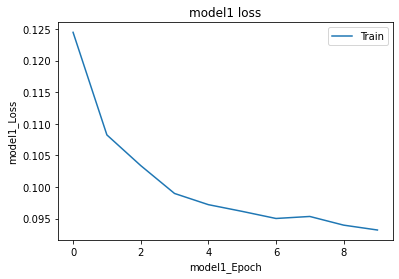

In [14]:
# 트레이닝 Epoch에 따라 Loss의 변화를 그래프로 시각화하는 코드입니다.
plt.plot(model1_history.history['loss']) 
plt.title('model1 loss')
plt.ylabel('model1_Loss')
plt.xlabel('model1_Epoch')
plt.legend(['Train'],loc='upper right')
plt.show()

In [15]:
#with tf.device('/gpu:0'):   

#Resnet
    def create_model3():
        inputs=Input(x_train.shape[1:])
    
        bn=BatchNormalization()(inputs)
        x=Conv2D(256, kernel_size=3, strides=1, padding='same', activation='relu')(bn)
    
        bn=BatchNormalization()(x)
        x2=Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu')(bn)
        concat=concatenate([x, x2], axis=3)
        
        bn=BatchNormalization()(concat)
        x2=Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')(bn)
        concat=concatenate([concat, x2], axis=3)
        
        bn=BatchNormalization()(concat)
        x2=Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(bn)
        concat=concatenate([concat, x2], axis=3)
        bn=BatchNormalization()(concat)
        x2=Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(bn)
        concat=concatenate([concat, x2], axis=3)
        bn=BatchNormalization()(concat)
        x2=Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(bn)
        concat=concatenate([concat, x2], axis=3)
        
        bn=BatchNormalization()(concat)
        x=Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(bn)
        concat=concatenate([concat, x], axis=3)
        bn=BatchNormalization()(concat)
        x=Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(bn)
        concat=concatenate([concat, x], axis=3)
    
        bn=BatchNormalization()(concat)
        outputs=Conv2D(1, kernel_size=3, strides=1, padding='same', activation='relu')(bn)
    
        model=Model(inputs=inputs, outputs=outputs)
    
        return model

    early_stopping = EarlyStopping(patience=5, min_delta=0, monitor='val_loss') 
    model3 = create_model3()
    model3.compile(loss="mae", optimizer="adam", metrics=[maeOverFscore_keras, fscore_keras])
    model3_history = model3.fit(x_train, y_train, batch_size=10, epochs = 3, verbose=1)

Epoch 1/3
74061/74061 [==============================] - 710s 10ms/step - loss: 0.1222 - maeOverFscore_keras: 152992.0781 - fscore_keras: 0.3623
Epoch 2/3
74061/74061 [==============================] - 709s 10ms/step - loss: 0.1151 - maeOverFscore_keras: 221053.6250 - fscore_keras: 0.3925
Epoch 3/3
74061/74061 [==============================] - 712s 10ms/step - loss: 0.1077 - maeOverFscore_keras: 25927.5137 - fscore_keras: 0.4947


In [16]:
pred = []
pred = model3.predict(x_test)
print(maeOverFscore_keras(y_test, pred))

pred = model3.predict(test)
submission.iloc[:,1:] = pred.reshape(-1, 1600)
submission.to_csv('f14_test2.csv', index = False)

tf.Tensor(2.3090997, shape=(), dtype=float32)


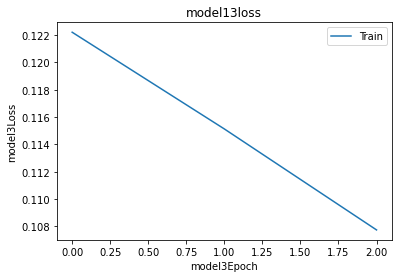

In [17]:
# 트레이닝 Epoch에 따라 Loss의 변화를 그래프로 시각화하는 코드입니다.
plt.plot(model3_history.history['loss']) 
plt.title('model13loss')
plt.ylabel('model3Loss')
plt.xlabel('model3Epoch')
plt.legend(['Train'],loc='upper right')
plt.show()

In [12]:
#with tf.device('/gpu:0'):   

#vgg16 변형 
def create_model4():
    inputs=Input(x_train.shape[1:])
    bn=BatchNormalization()(inputs)
        
    x = Conv2D(64, (3, 3), activation='relu', strides=1, padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(bn)
    x = Conv2D(64, (3, 3), activation='relu', strides=1, padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)

    x = Conv2D(128, (3, 3), activation='relu', strides=1, padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)
    x = Conv2D(128, (3, 3), activation='relu', strides=1, padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)

    x = Conv2D(256, (3, 3), activation='relu', strides=1, padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)
    x = Conv2D(256, (3, 3), activation='relu', strides=1, padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)
    x = Conv2D(256, (3, 3), activation='relu', strides=1, padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)

    x = Conv2D(512, (3, 3), activation='relu', strides=1, padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)
    x = Conv2D(512, (3, 3), activation='relu', strides=1, padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)
    x = Conv2D(512, (3, 3), activation='relu', strides=1, padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)
 
    x = Conv2D(512, (3, 3), activation='relu', strides=1, padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)
    x = Conv2D(512, (3, 3), activation='relu', strides=1, padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)
    x = Conv2D(512, (3, 3), activation='relu', strides=1, padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)

    bn=BatchNormalization()(x)
    
    outputs=Conv2D(1, (1,1), strides=1, padding='same', activation='relu')(bn)
    
    model=Model(inputs=inputs, outputs=outputs)
    
    return model

early_stopping = EarlyStopping(patience=5, min_delta=0, monitor='val_loss') 
model4 = create_model4()
model4.compile(loss="mae", optimizer="adam", metrics=[maeOverFscore_keras, fscore_keras])
model4_history = model4.fit(x_train, y_train, batch_size=10, epochs = 1, verbose=1)

Epoch 1/1
74060/74061 [============================>.] - ETA: 0s - loss: 0.5122 - maeOverFscore_keras: 19717916.0000 - fscore_keras: 1.7326e-04

C:\Users\seozo\.conda\envs\abc\lib\site-packages\sklearn\metrics\_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\seozo\.conda\envs\abc\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\seozo\.conda\envs\abc\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


74061/74061 [==============================] - 1554s 21ms/step - loss: 0.5122 - maeOverFscore_keras: nan - fscore_keras: 1.7324e-04  


In [16]:
pred = []
pred = model4.predict(x_test)
print(maeOverFscore_keras(y_test, pred))

pred = model4.predict(test)
submission.iloc[:,1:] = pred.reshape(-1, 1600)
submission.to_csv('f14_test3.csv', index = False)

tf.Tensor(20960372.0, shape=(), dtype=float32)


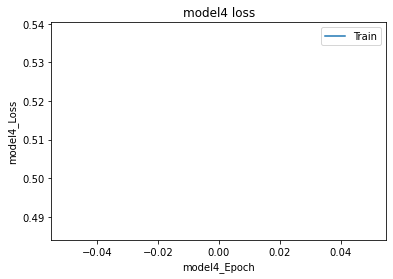

In [14]:
# 트레이닝 Epoch에 따라 Loss의 변화를 그래프로 시각화하는 코드입니다.
plt.plot(model4_history.history['loss']) 
plt.title('model4 loss')
plt.ylabel('model4_Loss')
plt.xlabel('model4_Epoch')
plt.legend(['Train'],loc='upper right')
plt.show()

In [21]:
#with tf.device('/gpu:0'):   

#alexnet 변형 
def create_model5():
    
    inputs=Input(x_train.shape[1:])
    bn=BatchNormalization()(inputs)
        
    x=Conv2D(96, (11,11), strides=1, padding='same', activation='relu')(bn)
    x=Conv2D(256, (5,5), strides=1,padding='same', activation='relu')(x)
    bn=BatchNormalization()(x) 
      
    x=Conv2D(384, (3,3), strides=1, padding='same', activation='relu')(bn)
    bn=BatchNormalization()(x)    
    

    x=Conv2D(384, (3,3), strides=1, padding='same', activation='relu')(bn)
    x=Conv2D(384, (3,3), strides=1, padding='same', activation='relu')(x)
    
    outputs=Conv2D(1, (1,1), strides=1, padding='same', activation='relu')(x)
    
    model=Model(inputs=inputs, outputs=outputs)
    
    return model

early_stopping = EarlyStopping(patience=5, min_delta=0, monitor='val_loss') 
model5 = create_model5()
model5.compile(loss="mae", optimizer="adam", metrics=[maeOverFscore_keras, fscore_keras])
model5_history = model5.fit(x_train, y_train, batch_size=10, epochs = 3, verbose=1)

Epoch 1/3
74061/74061 [==============================] - 491s 7ms/step - loss: 0.1462 - maeOverFscore_keras: 19843302.0000 - fscore_keras: 1.0449e-05
Epoch 2/3
74061/74061 [==============================] - 491s 7ms/step - loss: 0.1462 - maeOverFscore_keras: 19888724.0000 - fscore_keras: 0.0000e+00
Epoch 3/3
74061/74061 [==============================] - 483s 7ms/step - loss: 0.1462 - maeOverFscore_keras: 19981670.0000 - fscore_keras: 0.0000e+00


In [22]:
pred = []
pred = model5.predict(x_test)
print(maeOverFscore_keras(y_test, pred))

pred = model5.predict(test)
submission.iloc[:,1:] = pred.reshape(-1, 1600)
submission.to_csv('f14_test4.csv', index = False)

tf.Tensor(20960372.0, shape=(), dtype=float32)


In [ ]:
# 트레이닝 Epoch에 따라 Loss의 변화를 그래프로 시각화하는 코드입니다.
plt.plot(model5_history.history['loss']) 
plt.title('model5 loss')
plt.ylabel('model5_Loss')
plt.xlabel('model5_Epoch')
plt.legend(['Train'],loc='upper right')
plt.show()